Unique values in 'loan_status' column: loan_status
Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: proportion, dtype: float64
ROC-AUC Score: 0.9904854372894676


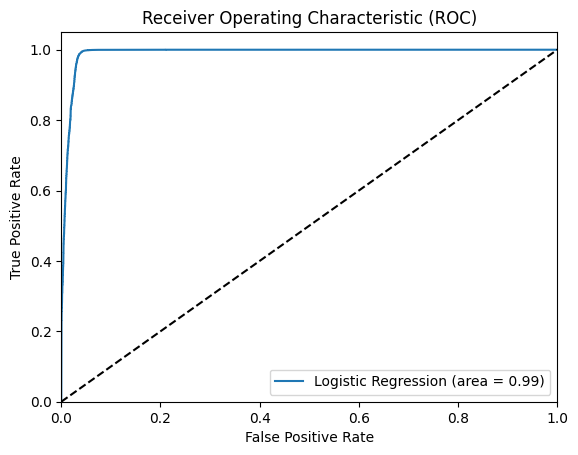

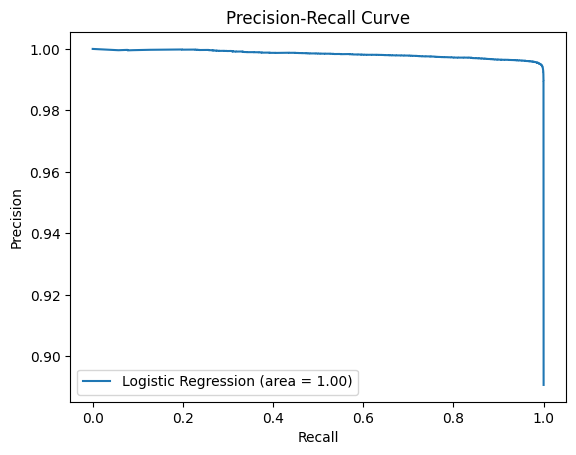

In [1]:
# Import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Import data
loan_data = pd.read_csv(r'C:\Users\HP\Desktop\Desktop2\Trash\loan.csv', low_memory=False)

# Drop columns with less than 20% non-null values (i.e., more than 80% null values)
threshold = loan_data.shape[0] * 0.2
loan_data.dropna(thresh=threshold, axis=1, inplace=True)

# Drop all redundant and forward-looking columns
loan_data.drop(columns=['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title',
                        'zip_code', 'next_pymnt_d', 'recoveries', 'collection_recovery_fee',
                        'total_rec_prncp', 'total_rec_late_fee'], inplace=True)

# Explore the unique values in the loan_status column
print("Unique values in 'loan_status' column:", loan_data['loan_status'].value_counts(normalize=True))

# Create a new column based on the loan_status column that will be our target variable
loan_data['good_bad'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                               'Late (31-120 days)',
                                                               'Does not meet the credit policy. Status:Charged Off']),
                                 0, 1)

# Drop the original 'loan_status' column
loan_data.drop(columns=['loan_status'], inplace=True)

# Define features and target
X = loan_data.drop('good_bad', axis=1)
y = loan_data['good_bad']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define preprocessing for numeric columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Define preprocessing for categorical columns
categorical_features = X.select_dtypes(include=['object']).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create the preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LogisticRegression(solver='liblinear', random_state=42))])

# Train the model
pipeline.fit(X_train, y_train)

# Predict probabilities
probabilities = pipeline.predict_proba(X_test)[:, 1]

# Compute the ROC-AUC score
roc_auc = roc_auc_score(y_test, probabilities)
print("ROC-AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, probabilities)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, probabilities)
pr_auc = auc(recall, precision)
plt.figure()
plt.plot(recall, precision, label='Logistic Regression (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [3]:
import pandas as pd
import numpy as np

# Function to clean up the emp_length column, assign 0 to NaNs, and convert to numeric
def emp_length_converter(df, column):
    df[column] = df[column].str.replace(r'\+ years', '', regex=True)
    df[column] = df[column].str.replace(r'< 1 year', '0', regex=True)
    df[column] = df[column].str.replace(r' years', '', regex=True)
    df[column] = df[column].str.replace(r' year', '', regex=True)
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Convert non-numeric to NaN
    df[column] = df[column].fillna(value=0)  # Fill NaNs with 0

# Function to convert date columns to datetime format and create a new column as a difference in months
def date_columns(df, column):
    today_date = pd.to_datetime('2020-08-01')
    df[column] = pd.to_datetime(df[column], format="%b-%y", errors='coerce')  # Convert to datetime
    df['mths_since_' + column] = (today_date.year - df[column].dt.year) * 12 + (today_date.month - df[column].dt.month)
    df['mths_since_' + column] = df['mths_since_' + column].fillna(0)  # Fill NaNs with 0

# Example usage
# Load your data
# df = pd.read_csv('your_data_file.csv')

# Apply the functions
# emp_length_converter(df, 'emp_length')
# date_columns(df, 'issue_d')


In [5]:
import pandas as pd
from scipy.stats import chi2_contingency

# First divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include='object').copy()
X_train_num = X_train.select_dtypes(include='number').copy()

# Define an empty dictionary to store chi-squared test results
chi2_check = {'Feature': [], 'p-value': []}

# Loop over each column in the categorical subset to calculate chi-squared statistic with the target variable
for column in X_train_cat:
    # Create a contingency table
    contingency_table = pd.crosstab(y_train, X_train_cat[column])
    # Perform the chi-squared test
    chi, p, dof, ex = chi2_contingency(contingency_table)
    chi2_check['Feature'].append(column)
    chi2_check['p-value'].append(round(p, 10))

# Convert the dictionary to a DataFrame
chi2_result = pd.DataFrame(data=chi2_check)
chi2_result.sort_values(by='p-value', ascending=True, ignore_index=True, inplace=True)

# Since f_classif does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace=True)


C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [24] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


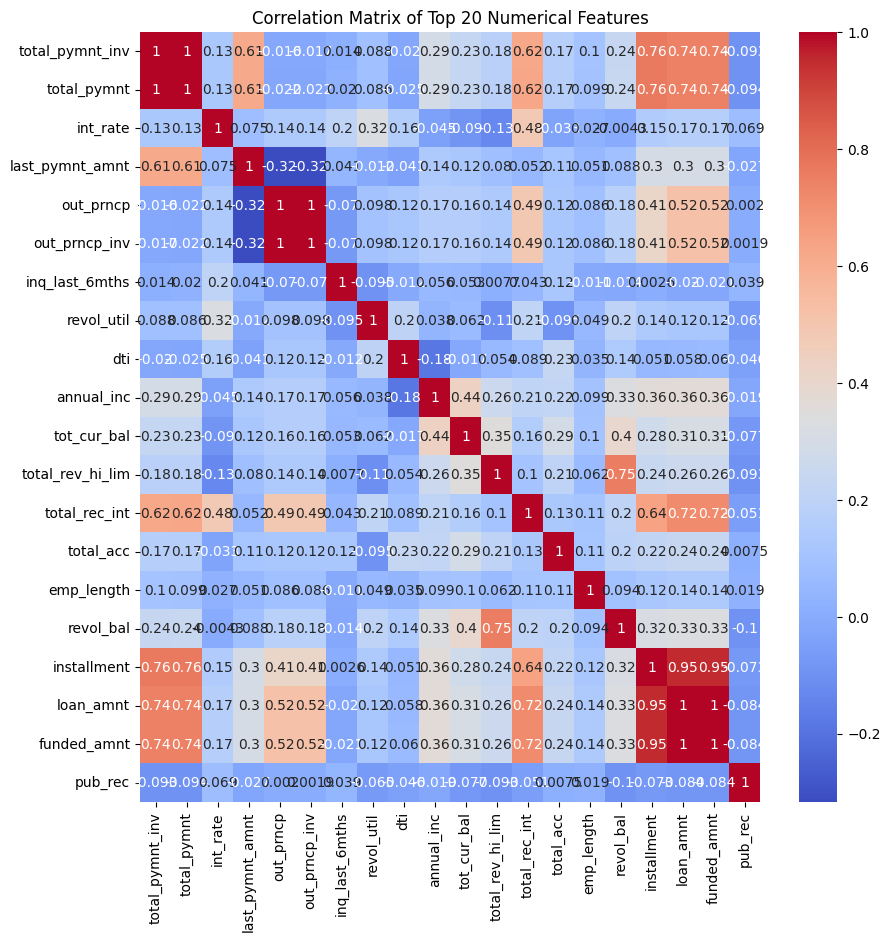

Columns to drop based on p-value > 0.05: ['mths_since_last_major_derog', 'mths_since_last_delinq', 'delinq_2yrs', 'acc_now_delinq', 'tot_coll_amt']


In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif

# Divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include='object').copy()
X_train_num = X_train.select_dtypes(include='number').copy()

# Define an empty dictionary to store chi-squared test results
chi2_check = {'Feature': [], 'p-value': []}

# Loop over each column in the categorical data to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check['Feature'].append(column)
    chi2_check['p-value'].append(round(p, 10))

# Convert the dictionary to a DataFrame
chi2_result = pd.DataFrame(data=chi2_check)
chi2_result.sort_values(by=['p-value'], ascending=True, ignore_index=True, inplace=True)

# Since f_classif does not accept missing values, do a crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace=True)

# Calculate F-Statistic and corresponding p-values
F_statistic, p_values = f_classif(X_train_num, y_train)

# Convert to a DataFrame
ANOVA_F_table = pd.DataFrame(data={
    'Numerical_Feature': X_train_num.columns.values,
    'F-Score': F_statistic,
    'p-value': p_values.round(decimals=10)
})
ANOVA_F_table.sort_values(by=['F-Score'], ascending=False, ignore_index=True, inplace=True)

# Save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.head(20)['Numerical_Feature'].tolist()

# Calculate pair-wise correlations between the top features
corrmat = X_train_num[top_num_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Top 20 Numerical Features')
plt.show()

# Save the names of columns to be dropped in a list (example for demonstration, adjust as needed)
drop_columns_list = ANOVA_F_table[ANOVA_F_table['p-value'] > 0.05]['Numerical_Feature'].tolist()

print("Columns to drop based on p-value > 0.05:", drop_columns_list)


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, ref_categories):
        self.ref_categories = ref_categories

    def fit(self, X, y=None):
        # Prepare a dictionary to store binning rules for each feature
        self.binning_rules = {}
        for category in self.ref_categories:
            feature, condition = category.split(':')
            feature = feature.strip()
            condition = condition.strip()
            if condition.startswith('>'):
                threshold = float(condition[1:].replace(',', ''))
                self.binning_rules[feature] = threshold
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for feature, threshold in self.binning_rules.items():
            if feature in X_transformed.columns:
                X_transformed[feature] = (X_transformed[feature] > threshold).astype(int)
        return X_transformed
def woe_discrete(df, cat_variabe_name, y_df):
    df = pd.concat([df[cat_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    df = df.sort_values(['WoE'])
    df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

'''
function to calculate WoE & IV of continuous variables
This is same as the function we defined earlier for discrete variables
The only difference are the 2 commented lines of code in the function that results in the df
being sorted by continuous variable values
'''
def woe_ordered_continuous(df, continuous_variabe_name, y_df):
    df = pd.concat([df[continuous_variabe_name], y_df], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_good']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_good'] = df['prop_good'] * df['n_obs']
    df['n_bad'] = (1 - df['prop_good']) * df['n_obs']
    df['prop_n_good'] = df['n_good'] / df['n_good'].sum()
    df['prop_n_bad'] = df['n_bad'] / df['n_bad'].sum()
    df['WoE'] = np.log(df['prop_n_good'] / df['prop_n_bad'])
    #df = df.sort_values(['WoE'])
    #df = df.reset_index(drop = True)
    df['diff_prop_good'] = df['prop_good'].diff().abs()
    df['diff_WoE'] = df['WoE'].diff().abs()
    df['IV'] = (df['prop_n_good'] - df['prop_n_bad']) * df['WoE']
    df['IV'] = df['IV'].sum()
    return df

# We set the default style of the graphs to the seaborn style. 
sns.set()
# function to plot WoE value
def plot_by_woe(df_WoE, rotation_of_x_axis_labels = 0):
    x = np.array(df_WoE.iloc[:, 0].apply(str))
    y = df_WoE['WoE']
    plt.figure(figsize=(18, 6))
    plt.plot(x, y, marker = 'o', linestyle = '--', color = 'k')
    plt.xlabel(df_WoE.columns[0])
    plt.ylabel('Weight of Evidence')
    plt.title(str('Weight of Evidence by ' + df_WoE.columns[0]))
    plt.xticks(rotation = rotation_of_x_axis_labels)

# create a list of all the reference categories, i.e. one category from each of the global features
ref_categories = ['mths_since_last_credit_pull_d:>75', 'mths_since_issue_d:>122', 'mths_since_earliest_cr_line:>434', 'total_rev_hi_lim:>79,780', 
                  'total_rec_int:>7,260', 'total_pymnt:>25,000', 'out_prncp:>15,437', 'revol_util:>1.0', 'inq_last_6mths:>4', 'dti:>35.191', 
                  'annual_inc:>150K', 'int_rate:>20.281', 'term:60', 'purpose:major_purch__car__home_impr', 'verification_status:Not Verified', 
                  'home_ownership:MORTGAGE', 'grade:G']	

# custom transformer class to create new categorical dummy features
class WoE_Binning(BaseEstimator, TransformerMixin):
    def __init__(self, X): # no *args or *kargs
        self.X = X
    def fit(self, X, y = None):
        return self #nothing else to do
    def transform(self, X):
        X_new = X.loc[:, 'grade:A': 'grade:G']
        X_new['home_ownership:OWN'] = X.loc[:,'home_ownership:OWN']
        X_new['home_ownership:MORTGAGE'] = X.loc[:,'home_ownership:MORTGAGE']
        X_new['home_ownership:OTHER_NONE_RENT'] = sum([X['home_ownership:OTHER'], X['home_ownership:NONE'], X['home_ownership:RENT']])
        X_new = pd.concat([X_new, X.loc[:, 'verification_status:Not Verified':'verification_status:Verified']], axis = 1)
        X_new['purpose:debt_consolidation'] = X.loc[:,'purpose:debt_consolidation']
        X_new['purpose:credit_card'] = X.loc[:,'purpose:credit_card']
        X_new['purpose:major_purch__car__home_impr'] = sum([X['purpose:major_purchase'], X['purpose:car'], X['purpose:home_improvement']])
        X_new['purpose:educ__ren_en__sm_b__mov'] = sum([X['purpose:educational'], X['purpose:renewable_energy'], X['purpose:small_business'], 
                                                        X['purpose:moving']])
        X_new['purpose:vacation__house__wedding__med__oth'] = sum([X['purpose:vacation'], X['purpose:house'], X['purpose:wedding'], 
                                                                   X['purpose:medical'], X['purpose:other']])
        X_new['term:36'] = np.where((X['term'] == 36), 1, 0)
        X_new['term:60'] = np.where((X['term'] == 60), 1, 0)
        X_new['int_rate:<7.071'] = np.where((X['int_rate'] <= 7.071), 1, 0)
        X_new['int_rate:7.071-10.374'] = np.where((X['int_rate'] > 7.071) & (X['int_rate'] <= 10.374), 1, 0)
        X_new['int_rate:10.374-13.676'] = np.where((X['int_rate'] > 10.374) & (X['int_rate'] <= 13.676), 1, 0)
        X_new['int_rate:13.676-15.74'] = np.where((X['int_rate'] > 13.676) & (X['int_rate'] <= 15.74), 1, 0)
        X_new['int_rate:15.74-20.281'] = np.where((X['int_rate'] > 15.74) & (X['int_rate'] <= 20.281), 1, 0)
        X_new['int_rate:>20.281'] = np.where((X['int_rate'] > 20.281), 1, 0)
        X_new['annual_inc:missing'] = np.where(X['annual_inc'].isnull(), 1, 0)
        X_new['annual_inc:<28,555'] = np.where((X['annual_inc'] <= 28555), 1, 0)
        X_new['annual_inc:28,555-37,440'] = np.where((X['annual_inc'] > 28555) & (X['annual_inc'] <= 37440), 1, 0)
        X_new['annual_inc:37,440-61,137'] = np.where((X['annual_inc'] > 37440) & (X['annual_inc'] <= 61137), 1, 0)
        X_new['annual_inc:61,137-81,872'] = np.where((X['annual_inc'] > 61137) & (X['annual_inc'] <= 81872), 1, 0)
        X_new['annual_inc:81,872-102,606'] = np.where((X['annual_inc'] > 81872) & (X['annual_inc'] <= 102606), 1, 0)
        X_new['annual_inc:102,606-120,379'] = np.where((X['annual_inc'] > 102606) & (X['annual_inc'] <= 120379), 1, 0)
        X_new['annual_inc:120,379-150,000'] = np.where((X['annual_inc'] > 120379) & (X['annual_inc'] <= 150000), 1, 0)
        X_new['annual_inc:>150K'] = np.where((X['annual_inc'] > 150000), 1, 0)
        X_new['dti:<=1.6'] = np.where((X['dti'] <= 1.6), 1, 0)
        X_new['dti:1.6-5.599'] = np.where((X['dti'] > 1.6) & (X['dti'] <= 5.599), 1, 0)
        X_new['dti:5.599-10.397'] = np.where((X['dti'] > 5.599) & (X['dti'] <= 10.397), 1, 0)
        X_new['dti:10.397-15.196'] = np.where((X['dti'] > 10.397) & (X['dti'] <= 15.196), 1, 0)
        X_new['dti:15.196-19.195'] = np.where((X['dti'] > 15.196) & (X['dti'] <= 19.195), 1, 0)
        X_new['dti:19.195-24.794'] = np.where((X['dti'] > 19.195) & (X['dti'] <= 24.794), 1, 0)
        X_new['dti:24.794-35.191'] = np.where((X['dti'] > 24.794) & (X['dti'] <= 35.191), 1, 0)
        X_new['dti:>35.191'] = np.where((X['dti'] > 35.191), 1, 0)
        X_new['inq_last_6mths:missing'] = np.where(X['inq_last_6mths'].isnull(), 1, 0)
        X_new['inq_last_6mths:0'] = np.where((X['inq_last_6mths'] == 0), 1, 0)
        X_new['inq_last_6mths:1-2'] = np.where((X['inq_last_6mths'] >= 1) & (X['inq_last_6mths'] <= 2), 1, 0)
        X_new['inq_last_6mths:3-4'] = np.where((X['inq_last_6mths'] >= 3) & (X['inq_last_6mths'] <= 4), 1, 0)
        X_new['inq_last_6mths:>4'] = np.where((X['inq_last_6mths'] > 4), 1, 0)
        X_new['revol_util:missing'] = np.where(X['revol_util'].isnull(), 1, 0)
        X_new['revol_util:<0.1'] = np.where((X['revol_util'] <= 0.1), 1, 0)
        X_new['revol_util:0.1-0.2'] = np.where((X['revol_util'] > 0.1) & (X['revol_util'] <= 0.2), 1, 0)
        X_new['revol_util:0.2-0.3'] = np.where((X['revol_util'] > 0.2) & (X['revol_util'] <= 0.3), 1, 0)
        X_new['revol_util:0.3-0.4'] = np.where((X['revol_util'] > 0.3) & (X['revol_util'] <= 0.4), 1, 0)
        X_new['revol_util:0.4-0.5'] = np.where((X['revol_util'] > 0.4) & (X['revol_util'] <= 0.5), 1, 0)
        X_new['revol_util:0.5-0.6'] = np.where((X['revol_util'] > 0.5) & (X['revol_util'] <= 0.6), 1, 0)
        X_new['revol_util:0.6-0.7'] = np.where((X['revol_util'] > 0.6) & (X['revol_util'] <= 0.7), 1, 0)
        X_new['revol_util:0.7-0.8'] = np.where((X['revol_util'] > 0.7) & (X['revol_util'] <= 0.8), 1, 0)
        X_new['revol_util:0.8-0.9'] = np.where((X['revol_util'] > 0.8) & (X['revol_util'] <= 0.9), 1, 0)
        X_new['revol_util:0.9-1.0'] = np.where((X['revol_util'] > 0.9) & (X['revol_util'] <= 1.0), 1, 0)
        X_new['revol_util:>1.0'] = np.where((X['revol_util'] > 1.0), 1, 0)
        X_new['out_prncp:<1,286'] = np.where((X['out_prncp'] <= 1286), 1, 0)
        X_new['out_prncp:1,286-6,432'] = np.where((X['out_prncp'] > 1286) & (X['out_prncp'] <= 6432), 1, 0)
        X_new['out_prncp:6,432-9,005'] = np.where((X['out_prncp'] > 6432) & (X['out_prncp'] <= 9005), 1, 0)
        X_new['out_prncp:9,005-10,291'] = np.where((X['out_prncp'] > 9005) & (X['out_prncp'] <= 10291), 1, 0)
        X_new['out_prncp:10,291-15,437'] = np.where((X['out_prncp'] > 10291) & (X['out_prncp'] <= 15437), 1, 0)
        X_new['out_prncp:>15,437'] = np.where((X['out_prncp'] > 15437), 1, 0)
        X_new['total_pymnt:<10,000'] = np.where((X['total_pymnt'] <= 10000), 1, 0)
        X_new['total_pymnt:10,000-15,000'] = np.where((X['total_pymnt'] > 10000) & (X['total_pymnt'] <= 15000), 1, 0)
        X_new['total_pymnt:15,000-20,000'] = np.where((X['total_pymnt'] > 15000) & (X['total_pymnt'] <= 20000), 1, 0)
        X_new['total_pymnt:20,000-25,000'] = np.where((X['total_pymnt'] > 20000) & (X['total_pymnt'] <= 25000), 1, 0)
        X_new['total_pymnt:>25,000'] = np.where((X['total_pymnt'] > 25000), 1, 0)
        X_new['total_rec_int:<1,089'] = np.where((X['total_rec_int'] <= 1089), 1, 0)
        X_new['total_rec_int:1,089-2,541'] = np.where((X['total_rec_int'] > 1089) & (X['total_rec_int'] <= 2541), 1, 0)
        X_new['total_rec_int:2,541-4,719'] = np.where((X['total_rec_int'] > 2541) & (X['total_rec_int'] <= 4719), 1, 0)
        X_new['total_rec_int:4,719-7,260'] = np.where((X['total_rec_int'] > 4719) & (X['total_rec_int'] <= 7260), 1, 0)
        X_new['total_rec_int:>7,260'] = np.where((X['total_rec_int'] > 7260), 1, 0)
        X_new['total_rev_hi_lim:missing'] = np.where(X['total_rev_hi_lim'].isnull(), 1, 0)
        X_new['total_rev_hi_lim:<6,381'] = np.where((X['total_rev_hi_lim'] <= 6381), 1, 0)
        X_new['total_rev_hi_lim:6,381-19,144'] = np.where((X['total_rev_hi_lim'] > 6381) & (X['total_rev_hi_lim'] <= 19144), 1, 0)
        X_new['total_rev_hi_lim:19,144-25,525'] = np.where((X['total_rev_hi_lim'] > 19144) & (X['total_rev_hi_lim'] <= 25525), 1, 0)
        X_new['total_rev_hi_lim:25,525-35,097'] = np.where((X['total_rev_hi_lim'] > 25525) & (X['total_rev_hi_lim'] <= 35097), 1, 0)
        X_new['total_rev_hi_lim:35,097-54,241'] = np.where((X['total_rev_hi_lim'] > 35097) & (X['total_rev_hi_lim'] <= 54241), 1, 0)
        X_new['total_rev_hi_lim:54,241-79,780'] = np.where((X['total_rev_hi_lim'] > 54241) & (X['total_rev_hi_lim'] <= 79780), 1, 0)
        X_new['total_rev_hi_lim:>79,780'] = np.where((X['total_rev_hi_lim'] > 79780), 1, 0)
        X_new['mths_since_earliest_cr_line:missing'] = np.where(X['mths_since_earliest_cr_line'].isnull(), 1, 0)
        X_new['mths_since_earliest_cr_line:<125'] = np.where((X['mths_since_earliest_cr_line'] <= 125), 1, 0)
        X_new['mths_since_earliest_cr_line:125-167'] = np.where((X['mths_since_earliest_cr_line'] > 125) & (X['mths_since_earliest_cr_line'] <= 167), 1, 0)
        X_new['mths_since_earliest_cr_line:167-249'] = np.where((X['mths_since_earliest_cr_line'] > 167) & (X['mths_since_earliest_cr_line'] <= 249), 1, 0)
        X_new['mths_since_earliest_cr_line:249-331'] = np.where((X['mths_since_earliest_cr_line'] > 249) & (X['mths_since_earliest_cr_line'] <= 331), 1, 0)
        X_new['mths_since_earliest_cr_line:331-434'] = np.where((X['mths_since_earliest_cr_line'] > 331) & (X['mths_since_earliest_cr_line'] <= 434), 1, 0)
        X_new['mths_since_earliest_cr_line:>434'] = np.where((X['mths_since_earliest_cr_line'] > 434), 1, 0)
        X_new['mths_since_issue_d:<79'] = np.where((X['mths_since_issue_d'] <= 79), 1, 0)
        X_new['mths_since_issue_d:79-89'] = np.where((X['mths_since_issue_d'] > 79) & (X['mths_since_issue_d'] <= 89), 1, 0)
        X_new['mths_since_issue_d:89-100'] = np.where((X['mths_since_issue_d'] > 89) & (X['mths_since_issue_d'] <= 100), 1, 0)
        X_new['mths_since_issue_d:100-122'] = np.where((X['mths_since_issue_d'] > 100) & (X['mths_since_issue_d'] <= 122), 1, 0)
        X_new['mths_since_issue_d:>122'] = np.where((X['mths_since_issue_d'] > 122), 1, 0)
        X_new['mths_since_last_credit_pull_d:missing'] = np.where(X['mths_since_last_credit_pull_d'].isnull(), 1, 0)
        X_new['mths_since_last_credit_pull_d:<56'] = np.where((X['mths_since_last_credit_pull_d'] <= 56), 1, 0)
        X_new['mths_since_last_credit_pull_d:56-61'] = np.where((X['mths_since_last_credit_pull_d'] > 56) & (X['mths_since_last_credit_pull_d'] <= 61), 1, 0)
        X_new['mths_since_last_credit_pull_d:61-75'] = np.where((X['mths_since_last_credit_pull_d'] > 61) & (X['mths_since_last_credit_pull_d'] <= 75), 1, 0)
        X_new['mths_since_last_credit_pull_d:>75'] = np.where((X['mths_since_last_credit_pull_d'] > 75), 1, 0)
        X_new.drop(columns = ref_categories, inplace = True)
        return X_new

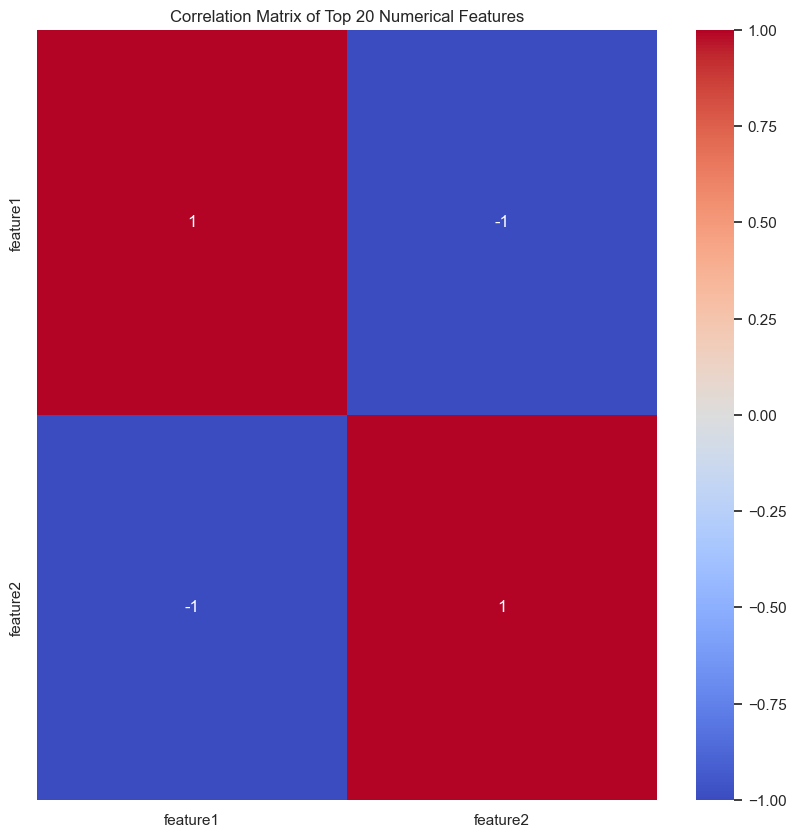

Columns to drop based on p-value > 0.05: ['feature1', 'feature2']


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif

# Divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include='object').copy()
X_train_num = X_train.select_dtypes(include='number').copy()

# Define an empty dictionary to store chi-squared test results
chi2_check = {'Feature': [], 'p-value': []}

# Loop over each column in the categorical data to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check['Feature'].append(column)
    chi2_check['p-value'].append(round(p, 10))

# Convert the dictionary to a DataFrame
chi2_result = pd.DataFrame(data=chi2_check)
chi2_result.sort_values(by=['p-value'], ascending=True, ignore_index=True, inplace=True)

# Since f_classif does not accept missing values, do a crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace=True)

# Calculate F-Statistic and corresponding p-values
F_statistic, p_values = f_classif(X_train_num, y_train)

# Convert to a DataFrame
ANOVA_F_table = pd.DataFrame(data={
    'Numerical_Feature': X_train_num.columns.values,
    'F-Score': F_statistic,
    'p-value': p_values.round(decimals=10)
})
ANOVA_F_table.sort_values(by=['F-Score'], ascending=False, ignore_index=True, inplace=True)

# Save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.head(20)['Numerical_Feature'].tolist()

# Calculate pair-wise correlations between the top features
corrmat = X_train_num[top_num_features].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(corrmat, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Top 20 Numerical Features')
plt.show()

# Save the names of columns to be dropped in a list (example for demonstration, adjust as needed)
drop_columns_list = ANOVA_F_table[ANOVA_F_table['p-value'] > 0.05]['Numerical_Feature'].tolist()

print("Columns to drop based on p-value > 0.05:", drop_columns_list)
